# MLP - CWE Classifier

- **Training set**: LO_SARD102 (0.75 split)
- **Test/Validation set:** LO_SARD102 (0.25 split)
- **Features**: word2vec average
- **Class imbalance processing**: Class weights

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from helper_functions import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

/home/scheuererra68323/venv37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Load labeled dataset

In [2]:
X = numpy.stack(
    pd.read_hdf('LO_SARD102_CweCluster_word2vec.h5', key='X').word2vec_avg,
    axis=0
)
print(X.shape)

(23003, 100)


In [3]:
# CWE by Research Concepts (CWE-IDs)
researchconcepts = [284, 435, 664, 682, 691, 693, 697, 703, 707, 710]

y = numpy.array(pd.read_hdf('LO_SARD102_CweCluster_word2vec.h5', key='y'))

# delete CWE clusters w/o any examples
_y = pd.DataFrame(y, columns=researchconcepts)
_y = _y.loc[:, (_y != 0).any(axis=0)]

researchconcepts = list(_y.columns)
print(researchconcepts)

y = _y.values
print(y.shape)

[664, 682, 691, 693, 697, 707, 710]
(23003, 7)


## Create train, test, validation sets

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2


print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print()
print(f"X_val: {X_val.shape}")
print(f"Y_val: {Y_val.shape}")
print()
print(f"X_test: {X_test.shape}")
print(f"Y_test: {Y_test.shape}")

X_train: (13801, 100)
Y_train: (13801, 7)

X_val: (4601, 100)
Y_val: (4601, 7)

X_test: (4601, 100)
Y_test: (4601, 7)


In [5]:
class_weights = [( 1 / _y[_class].value_counts()[1] ) * Y_train.shape[0] / Y_train.shape[1] for _class in researchconcepts]
class_weights = {i:class_weights[i] for i in range(len(class_weights))}
class_weights

{0: 0.1465416551636263,
 1: 2.938258462848627,
 2: 2.5805908750934927,
 3: 0.17432108121763296,
 4: 17.923376623376623,
 5: 0.14799365174684195,
 6: 1.481270795320382}

## Define and train model

In [6]:
num_classes = Y_train.shape[1]
model = keras.Sequential(
        [
            layers.Dense(100,
                         input_dim=X_train.shape[1],
                         kernel_initializer='glorot_uniform',
                         activation=tf.nn.relu),
            
            layers.Dropout(0.1),
                        
            layers.Dense(100,
                         kernel_initializer='glorot_uniform',
                         activation=tf.nn.relu),
            
            layers.Dense(64,
                         kernel_initializer='glorot_uniform',
                         activation=tf.nn.relu),
            
            layers.Dense(32,
                         kernel_initializer='glorot_uniform',
                         activation=tf.nn.relu),
            
            layers.Dense(num_classes, 
                         kernel_initializer='glorot_uniform', 
                         activation=tf.nn.sigmoid),
        ]
    )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 231       
Total params: 28,975
Trainable params: 28,975
Non-trainable params: 0
____________________________________________________

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    batch_size=128,
                    epochs=75,
                    verbose=False,
                    validation_data=(X_val, Y_val),
                    class_weight=class_weights
                   )

## Evaluation on test

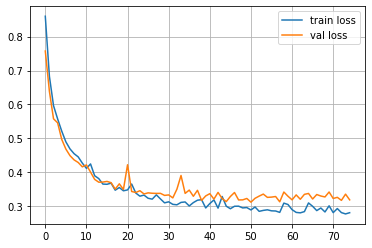

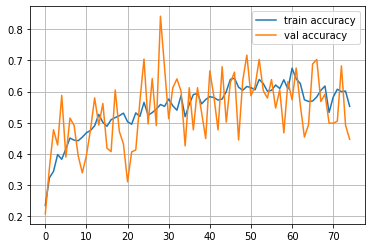

In [8]:
plot_loss(history)
plot_accuracy(history)

In [9]:
Y_pred = numpy.round(model.predict(X_test))
print(classification_report(Y_test, Y_pred, digits=4,
                           target_names=["CWE-"+str(cwe_id) for cwe_id in researchconcepts]
                           ))

              precision    recall  f1-score   support

     CWE-664     0.9949    0.6602    0.7937      2634
     CWE-682     0.5676    0.3621    0.4421       116
     CWE-691     0.9615    0.4335    0.5976       173
     CWE-693     0.9827    0.9158    0.9480      2291
     CWE-697     0.7500    0.5625    0.6429        32
     CWE-707     0.9813    0.8682    0.9213      2716
     CWE-710     0.7391    0.2528    0.3767       269

   micro avg     0.9762    0.7773    0.8655      8231
   macro avg     0.8539    0.5793    0.6746      8231
weighted avg     0.9709    0.7773    0.8555      8231
 samples avg     0.7438    0.7367    0.7372      8231



/home/scheuererra68323/venv37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
conf_matrix = get_confusion_matrix(model, X_test, Y_test)
print(conf_matrix)

# implementation for highlighting main diagonal taken from 
# https://stackoverflow.com/a/56916309
def highlight_diag(df):
    a = numpy.full(df.shape, '', dtype='<U24')
    numpy.fill_diagonal(a, 'background-color: yellow')
    return pd.DataFrame(a, index=df.index, columns=df.columns)


pd.DataFrame(conf_matrix, columns=researchconcepts, index=researchconcepts).style.apply(highlight_diag, axis=None)

[[1365    8   29    1   17 1098  116]
 [   3   79    0    5    0   10    1]
 [   0    4  101    1    0    8    2]
 [   3    3    2  127    1 1287    3]
 [   0    1    0    0   25    4    0]
 [   5    1    0    1    0  156   10]
 [   1    0    1    0    0    5  117]]


,664,682,691,693,697,707,710
664,1365,8,29,1,17,1098,116
682,3,79,0,5,0,10,1
691,0,4,101,1,0,8,2
693,3,3,2,127,1,1287,3
697,0,1,0,0,25,4,0
707,5,1,0,1,0,156,10
710,1,0,1,0,0,5,117


In [12]:
model.save('CWE_MLP_Var2_word2vec_weightedClasses.h5')

In [ ]:
# model.load_weights('CWE_MLP_Var2_word2vec_weightedClasses.h5')